In [1]:
import os
import random
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score


# Configure Matplotlib display style
plt.style.use('seaborn-dark-palette')
# Configure Matplotlib default figsize
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6

# Configure TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Introduction

In this notebook will be comparing the performance of two CNN models for image classification. For the dataset we will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and the two model used are the VGG16 and ResNet50. Transfer learning is used in training the models to speed up the process. We compare the training process for both models and they are evaluated on test prediction accuracy.

### CIFAR-10 dataset

The CIFAR-10 dataset consists of 60,000 32x32 color images with 6,000 images per class. There are 50,000 training images and 10,000 test images. The ten different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

This dataset was chosen primarily because it is a good benchmark dataset, due being one of the most commonly used. Another factor in selecting this dataset was computational cost; larger datasets are usually better for training models however they take longer to train. This dataset provides a good balance between dataset size and computational complexity.

### VGG16

VGG Nets were invented by Simonyan and Zisserman from Visual Geometry Group (VGG) at University of Oxford in 2014 and published in the paper ["Very deep convolutional networks for large-scale image recognition"](https://arxiv.org/pdf/1409.1556.pdf). Despite being the runner-up in the 2014 ImageNet competition that year (GoogLeNet/Inception v1 won that year) it continues to be commonly used due to its relatively simple design and good performance. 

The key idea of VGG Nets is that increasing model depth (i.e. increasing the number of layers) could improve model accuracy. It was able to do this by using smaller convolutions, 3x3 with stride 1 compared to AlexNet which was 11x11 with stride 4. VGG16 has 16 layers compared to Alexnet's eight. The researchers also released VGG19 with 19 layers however the performance difference between VGG16 and VGG19 is minimal so in practice VGG16 is more commonly used due to having less complexity. 

The model was trained on 224x224 RGB images. The only preprocessing was subtracting the mean RGB (computed from the training set) from each pixel. On top of the convolutional layers there were three dense, fully-connected layers: the first two having 4096 neurons and the last being the 1000 neuron softmax output layer. ReLU activation function used throughout. It was trained using Stochastic Gradient Descent (SGD) in minibatches of 256. Learning rate was initially set to 1e-3, decreasing by a factor of ten when validation stopped increasing, minimum learning rate was 1e-5.

By increasing the model depth performance improved, but this also creates several issues. Firstly the vanishing/exploding gradient problem and secondly the "degradation problem" of expanding models, where training accuracy starts to saturate and then decline as depth increases. 

### ResNet50

Residual Networks (ResNets) were published in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385.pdf) and entered into ImageNet in 2015, winning the competition that year. They resolve the problems present in the VGG model by using residual connections which connect the output of one layer with the input of an earlier layer. This allowed for using much deeper models than before as the model then behaved more like an ensemble of shallower networks than one large, deep network. For this project we use ResNet50 with 50 layers but in the paper they created models with up to 152 layers. Deep residual networks utilizing residual connections have since been used in many models, including in the architecture of AlphaZero and AlphaFold. I chose these models in particular to demonstrate the improvement residual connections can make to performance. 

The training of ResNet was similar to VGG16. Images were cropped to 224x224 and per-pixel mean subtracted. Stochastic Gradient Descent was used with a mini-batch size of 256. The initial learning rate was 0.1 and decayed by 0.1 on each plateau however the minimum learning rate is not given.

ResNet was also trained on CIFAR-10 with different depths, the results are displayed in the image below. The focus here was examining behaviours of extremely deep networks rather than optimizing for state-of-the-art results. They used the 32x32 images as input and were able to achieve a minimum error of 6.43% (i.e.: 93.57% accuracy) using a model with 110 layers.

<img src="Images/ResNet_CIFAR_10.png" alt="ResNet CIFAR-10 results" width="420"/>

### Transfer Learning

Transfer learning is where a previously trained model is trained on new data. The idea is that the "knowledge" the model has learned can be transferred to the new problem, saving training time. This is similar to the idea of [transfer of learning](https://en.wikipedia.org/wiki/Transfer_of_learning) from cognitive psychology.

There are several possible ways that transfer learning can be implemented, [this Keras guide](https://keras.io/guides/transfer_learning/) gives a good introduction to the topic. There are four main approaches which are well illustrated in the rubric below (from [here](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)). Since this dataset is relatively small for a deep learning dataset and ImageNet is fairly similar in content to CIFAR-10 we freeze all the layers in the base model.

![transfer learning image](Images/transfer_learning.png)

### Training method

As mentioned above, we use transfer learning and freeze all the layers of the base models. To this we add two fully connected dense layers of 400 and 200 and an output layer of ten neurons with softmax activation. This choice of architecture is intended to replicate the original models, albeit smaller for computational cost reasons. Dropout of 0.2 is used between these layers to prevent overfitting.

Stochastic Gradient Descent is used as the optimizer with initial learning rate of 0.001, decaying on plateaus by a factor of 0.3. Adam optimizer was tried however SGD was found to perform better. Categorical cross-entropy is used as the loss function and for the evaluation metric we use accuracy. Although accuracy is a very basic metric, in this context (i.e. multi-class classification with no class imbalance) I believe this to be the optimal evaluation metric.

The images were resized to 224x224 for the model. Training with 32x32 was initially attempted however the performance was disappointing and took a long time to train. Resizing the images meant that the model was able to learn much faster, albeit with an impact on available RAM restricting batch size somewhat. However, a batch size of 16 yielded better results than 32 or 64 so this was used.

In [2]:
# Settings for model training
NUM_EPOCHS = 12
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224, 3)

# Dictionary mapping integer label to class name
LABEL_NAMES = dict(enumerate(['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                              'Dog', 'Frog', 'Horse', 'Ship', 'Truck']))
# Seed used for reproducible results
SEED = 42

In [89]:
# Helper functions

def set_random_seed(seed=SEED):
    """
    Sets random seed for random number generators,
    used for reproducibility.
    
    Params:
        seed : (int)
            The integer to used to seed
    Returns:
        None
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def view_data_aug(image,
                  height_shift=0.1,
                  width_shift=0.1,
                  brightness_shift=0.1):
    """
    A function to display an image before and after data augmentation.
    Used for selecting optimal augmentation parameters. Uses the
    ImageDataGenerator.apply_transform function to perform augmentations.
    
    Params:
        image : (numpy.array)
            The image to display, 3D numpy array
        height_shift : (float)
            The fraction of total height to shift
        width_shift : (float)
            The fraction of total width to shift
        brightness_shift : (float)
            The fraction of image brightness to shift
    Returns:
        None
    """
    # Instantiate the generator to perform data augmentation
    datagen = ImageDataGenerator()
    # Create a 3x3 subplots to show the images
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    # View height shift
    axes[0][0].imshow(image)
    axes[0][0].set_title('Original image')
    axes[0][1].imshow(datagen.apply_transform(image, {'tx': height_shift*image.shape[0]}))
    axes[0][1].set_title(f'height shifted +{height_shift:.0%}')
    axes[0][2].imshow(datagen.apply_transform(image, {'tx': -height_shift*image.shape[0]}))
    axes[0][2].set_title(f'height shifted -{height_shift:.0%}')
    # View width shift
    axes[1][0].imshow(image)
    axes[1][0].set_title('Original image')
    axes[1][1].imshow(datagen.apply_transform(image, {'ty': width_shift*image.shape[0]}))
    axes[1][1].set_title(f'Width shifted +{width_shift:.0%}')
    axes[1][2].imshow(datagen.apply_transform(image, {'ty': -width_shift*image.shape[0]}))
    axes[1][2].set_title(f'Width shifted -{width_shift:.0%}')
    # View brightness change
    axes[2][0].imshow(image)
    axes[2][0].set_title('Original image')
    axes[2][1].imshow(datagen.apply_transform(image, {'brightness': 1+brightness_shift}).astype(int))
    axes[2][1].set_title(f'Brightness increased +{brightness_shift:.0%}')
    axes[2][2].imshow(datagen.apply_transform(image, {'brightness': 1-brightness_shift}).astype(int))
    axes[2][2].set_title(f'Brightness decreased -{brightness_shift:.0%}')
    plt.show()

def get_model_results(model, history):
    """
    A function to store model results as a dictionary,
    which can be used for evaluation. Stores the models
    training history and also predctions for train, 
    validation and test data.
    
    Params:
        model : (keras.engine.functional.Functional)
            Trained Functional Keras model, to make predictions
        history : (keras.callbacks.History)
            History object for trained model, used to get 
            model training results for plotting.
    Returns:
        results : (dict)
            A dictionary to store model training history
            and predictions on train, validation and test.
    """
    # Create results dict by copying model training history
    results = history.history.copy()
    # Get predictions from model
    results['train_preds'] = model.predict(train_datagen.flow(X_train,
                                                              y_train,
                                                              shuffle=False,
                                                              batch_size=BATCH_SIZE))
    results['val_preds'] = model.predict(val_datagen.flow(X_val,
                                                          y_val,
                                                          shuffle=False,
                                                          batch_size=BATCH_SIZE))
    results['test_preds'] = model.predict(test_datagen.flow(X_test,
                                                            y_test,
                                                            shuffle=False,
                                                            batch_size=BATCH_SIZE))
    return results

def evaluate_model(model_results):
    """
    A function to evaluate model results. Displays the best
    epoch and loss & accuracy for train, validation and 
    test data.
    
    Params:
        model_results : (dict)
            A dictionary containing model training history and 
            model predictions.
    Returns:
        None
    """
    best_epoch = np.argmin(model_results['val_loss'])
    # Calculate categorical cross-entropy
    cce = tf.keras.losses.CategoricalCrossentropy()
    train_cce = cce(y_train, model_results['train_preds']).numpy()
    val_cce = cce(y_val, model_results['val_preds']).numpy()
    test_cce = cce(y_test, model_results['test_preds']).numpy()
    # Convert predictions from probabilities to 1D array of ints
    train_preds = model_results['train_preds'].argmax(axis=1)
    val_preds = model_results['val_preds'].argmax(axis=1)
    test_preds = model_results['test_preds'].argmax(axis=1)
    y_train_1D = y_train.argmax(axis=1)
    y_val_1D = y_val.argmax(axis=1)
    y_test_1D = y_test.argmax(axis=1)
    # Calculate accuracy
    train_acc = accuracy_score(y_train_1D, train_preds)
    val_acc = accuracy_score(y_val_1D, val_preds)
    test_acc = accuracy_score(y_test_1D, test_preds)
    # Display  results
    print(f'Best epoch: {best_epoch+1}')
    print('              CCE loss        Accuracy')
    print(f'Train: {train_cce:>13.4f} {train_acc:>15.2%}')
    print(f'Validation: {val_cce:>8.4f} {val_acc:>15.2%}')
    print(f'Test: {test_cce:>14.4f} {test_acc:>15.2%}')

def plot_training_history(model_results, model_name):
    """
    Plots model loss & accuracy training history
    for training & validation data.

    Params:
        model_results : (dict)
            Dictionary containg loss, val_loss, acc & val_acc arrays
            from model training history.
        model_name : (str)
            The model name to be used as image title
    Returns:
        None      
    """
    # Setting ggplot style for visualizations
    with plt.style.context('ggplot'):
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        # Plotting loss
        axes[0].plot(model_results['loss'], label='Train loss')
        axes[0].plot(model_results['val_loss'], label='Val loss')
        axes[0].set_title(f'{model_name} loss')
        axes[0].legend(loc='upper right')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Cross-entropy Loss')
        # Plotting accuracy
        axes[1].plot(model_results['accuracy'], label='Train acc')
        axes[1].plot(model_results['val_accuracy'], label='Val acc')
        axes[1].set_title(f'{model_name} accuracy')
        axes[1].legend(loc='lower right')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        plt.show()
        
def display_confusion_matrix(matrix, title=None):
    """
    Displays a confusion matrix of actual 
    and predicted values using a heatmap
    
    Params:
        cm : (np.array)
            2D confusion matrix
        title : (str, optional)
            The title to display in the heatmap
    Returns:
        None
    """
    # Creating a DataFrame that we can pass to heatmap
    df_cm = pd.DataFrame(matrix,
                         columns=LABEL_NAMES.values(),
                         index=LABEL_NAMES.values())
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(12, 10))
    # Plotting heatmap
    sns.heatmap(df_cm,
                cmap='Spectral',
                annot=True,
                # Specify decimal instead of scientific format
                fmt='d', 
                annot_kws={'size': 15})
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

### Load and prepare the dataset

The CIFAR-10 dataset is loaded from Keras datasets library. We one-hot-encode the labels since this is a multi-class problem and the model will output probabilities for each class. We split the data into training and validation using an 80/20 split, allowing 40k images for training and 10k for validation.

Exploratory Data Analysis (EDA) is kept to a minimum since this is such a commonly used dataset that all information about it is freely available online and EDA is not our main purpose. We view some random sample images to get a basic overview of the data and then view images with data augmentation applied

In [4]:
# Setting random seed for reproducibility
set_random_seed()

In [5]:
# Loading the dataset
(train_images, train_labels), (X_test, y_test) = datasets.cifar10.load_data()

In [6]:
# One-hot-encode labels
train_labels = to_categorical(train_labels)
y_test = to_categorical(y_test)

In [7]:
# Splitting data into train and validation subsets 80/20
X_train, X_val, y_train, y_val = train_test_split(train_images,
                                                  train_labels,
                                                  test_size=0.2,
                                                  random_state=SEED)

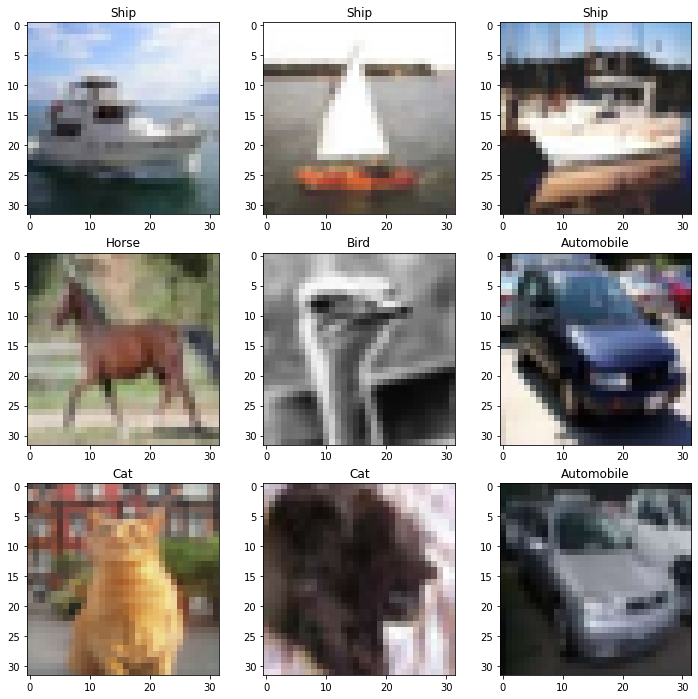

In [8]:
# Select random indices of images to view 
rand_idxs = np.random.randint(X_train.shape[0], size=9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
# Iterate through indices and axes
for idx, ax in zip(rand_idxs, axes.flatten()):
    # Get label name to display in this subplot
    label_name = LABEL_NAMES[train_labels[idx].argmax()]
    img = train_images[idx]
    ax.imshow(img)
    ax.set_title(label_name)

plt.show()

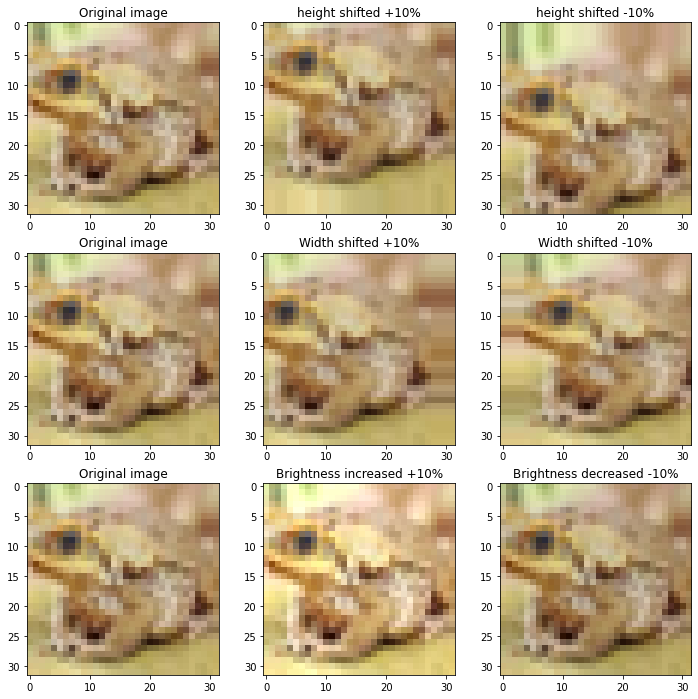

In [9]:
# Selecting a random image to view data augmentation
rand_idx = np.random.randint(X_train.shape[0])
img = X_train[rand_idx]

view_data_aug(img)

### Data augmentation

Data augmentation can really help a model to learn better and avoid overfitting. We apply width, height, and brightness augmentation as illustrated above. We also apply random horizontal flips.

### Creating the data generators and model

We use generators to load the data for the models and augment the images. The "create_generators" function is used for both models, we pass it the Keras preprocessing function and it returns the fitted generators. These take care of all image processing for the model. 

In [10]:
def create_generators(preprocessing_func):
    """
    Creates train, validation and test data generators. Data
    augmentation is applied to the training generator only.
    
    Parameters:
        preprocessing_func : (function)
            Uninstantiated preprocess_input function from Keras applications library
    Returns:
        train_datagen : (ImageDataGenerator)
            Data generator fitted on training data, performs data augmentation
        val_datagen : (ImageDataGenerator)
            Data generator fitted on validation data
        test_datagen : (ImageDataGenerator)
            Data generator fitted on test data  
    """
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_func,
                                       brightness_range=[0.9, 1.1],
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       horizontal_flip=True)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocessing_func)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_func)
    # Fitting the data to the generators
    train_datagen.fit(X_train)
    val_datagen.fit(X_val)
    test_datagen.fit(X_test)
    return train_datagen, val_datagen, test_datagen

In [11]:
# Get the generators for VGG16
train_datagen, val_datagen, test_datagen = create_generators(tf.keras.applications.vgg16.preprocess_input)

In [12]:
def create_model(base_model):
    """
    Creates a Keras model using functional API to be used for 
    transfer learning. Base model weights are frozen and 
    fully connected layers with dropout added.
    
    Parameters:
        base_model : (function)
            This should be an uninstatiated model function from
            the Keras applications library.
    Return:
        model : (keras.engine.functional.Functional)
            Returns a compiled Functional Keras model
    """
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    # Resize images to 224x224
    resized_input = tf.keras.layers.Resizing(INPUT_SHAPE[0],
                                             INPUT_SHAPE[1])(inputs)
    base_model = base_model(weights='imagenet',
                           include_top=False,
                           input_shape=INPUT_SHAPE,
                           input_tensor=resized_input)
    # Freeze the pretrained weights
    base_model.trainable = False
    # Adding fully-connected layers
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(200, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(10, activation='softmax')(x)
    # Compile the model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    # SGD used for optimizer
    opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
# Setting callbacks to be used in model training
callbacks = [
    # Stops training if no improvement for 2 epochs
    # and restores best weights
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=2,
                                     restore_best_weights=True,
                                     verbose=1),
    # Reduces learning-rate if validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.3,
                                         patience=1,
                                         verbose=1,
                                         min_lr=1e-5)
]

## Training the models

We use the "create_model" function above to create and compile both models, keeping everything the same for both models except the base model. We then train the model as below. Again, the same settings are used for both models.

Once the model is trained we use "get_model_results" to store the model training history and predictions in a dictionary, to be used for evaluation. We  then delete the current model and clear the memory before training the next model to ensure there is enough memory available.

In [14]:
# Creating the VGG16 model
model = create_model(tf.keras.applications.vgg16.VGG16)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584

In [15]:
# Training VGG16 model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                       validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                                       steps_per_epoch=len(X_train) // BATCH_SIZE,
                                       callbacks=callbacks,
                                       verbose=1,
                                       epochs=NUM_EPOCHS)

Epoch 1/12
2500/2500 [==============================] - 254s 100ms/step - loss: 1.1852 - accuracy: 0.6349 - val_loss: 0.5504 - val_accuracy: 0.8128
Epoch 2/12
2500/2500 [==============================] - 254s 102ms/step - loss: 0.7200 - accuracy: 0.7591 - val_loss: 0.4689 - val_accuracy: 0.8400
Epoch 3/12
2500/2500 [==============================] - 251s 100ms/step - loss: 0.6066 - accuracy: 0.7962 - val_loss: 0.4089 - val_accuracy: 0.8616
Epoch 4/12
2500/2500 [==============================] - 249s 99ms/step - loss: 0.5421 - accuracy: 0.8146 - val_loss: 0.3973 - val_accuracy: 0.8688
Epoch 5/12
2500/2500 [==============================] - 248s 99ms/step - loss: 0.4996 - accuracy: 0.8295 - val_loss: 0.3808 - val_accuracy: 0.8723
Epoch 6/12
2500/2500 [==============================] - 252s 101ms/step - loss: 0.4646 - accuracy: 0.8415 - val_loss: 0.3685 - val_accuracy: 0.8789
Epoch 7/12
2500/2500 [==============================] - 252s 101ms/step - loss: 0.4407 - accuracy: 0.8477 - val_lo

In [16]:
# Get model results to be used in evaluation
vgg_results = get_model_results(model, history)

In [17]:
# Saving trained model weights so that it can be loaded later
model.save_weights('VGG16_weights_7_9.h5')

In [18]:
# Deleting the current model, clearing keras
# session and using garbage collection to free memory
del model
tf.keras.backend.clear_session()
gc.collect()

# Resetting random seed
set_random_seed()

### Training the ResNet50 model

We now train the ResNet50 model using the same process as the VGG16.

In [19]:
# Get the generators for ResNet model
train_datagen, val_datagen, test_datagen = create_generators(tf.keras.applications.resnet.preprocess_input)

# Creating the model
model = create_model(tf.keras.applications.ResNet50)

In [20]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
          validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
          steps_per_epoch=len(X_train) // BATCH_SIZE,
          callbacks=callbacks,
          epochs=NUM_EPOCHS)

Epoch 1/12
2500/2500 [==============================] - 207s 82ms/step - loss: 0.7113 - accuracy: 0.7642 - val_loss: 0.3185 - val_accuracy: 0.8941
Epoch 2/12
2500/2500 [==============================] - 205s 82ms/step - loss: 0.4693 - accuracy: 0.8439 - val_loss: 0.2839 - val_accuracy: 0.9033
Epoch 3/12
2500/2500 [==============================] - 202s 81ms/step - loss: 0.4057 - accuracy: 0.8646 - val_loss: 0.2749 - val_accuracy: 0.9077
Epoch 4/12
2500/2500 [==============================] - 198s 79ms/step - loss: 0.3568 - accuracy: 0.8791 - val_loss: 0.2581 - val_accuracy: 0.9137
Epoch 5/12
2500/2500 [==============================] - 197s 79ms/step - loss: 0.3316 - accuracy: 0.8878 - val_loss: 0.2487 - val_accuracy: 0.9163
Epoch 6/12
2500/2500 [==============================] - 202s 81ms/step - loss: 0.3060 - accuracy: 0.8961 - val_loss: 0.2487 - val_accuracy: 0.9165

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/12
2500/2500 [===============

In [21]:
# Get model results to be used in evaluation
resnet_results = get_model_results(model, history)

In [22]:
# Saving trained model so that it can be loaded later
model.save_weights('ResNet_weights_7_9.h5')

# Evaluation

Now that we have trained the models we can compare their performance. We will start by evaluating the model predictions to see how well they performed.

The results below show that ResNet50 acheives the best test accuracy, 92.37% compared to VGG16's 88.73%. The best epoch for both models was the last epoch, suggesting that increasing the number of epochs could improve performance. However both models also performed better on training data than test, suggesting they could be overfitting slightly.

We then plot the training history for both models as shown in the visualizations below. As mentioned above, both models performed optimally on the last epoch however both are possibly close to overfitting at this point, suggesting increasing the number of epochs probably wouldn't be very beneficial without changing some other hyperparameters.

In [90]:
print('VGG16 results:')
evaluate_model(vgg_results)

VGG16 results:
Best epoch: 12
              CCE loss        Accuracy
Train:        0.2580          91.24%
Validation:   0.3293          89.12%
Test:         0.3469          88.93%


In [91]:
print('ResNet50 results:')
evaluate_model(resnet_results)

ResNet50 results:
Best epoch: 11
              CCE loss        Accuracy
Train:        0.1634          94.32%
Validation:   0.2224          92.45%
Test:         0.2319          92.30%


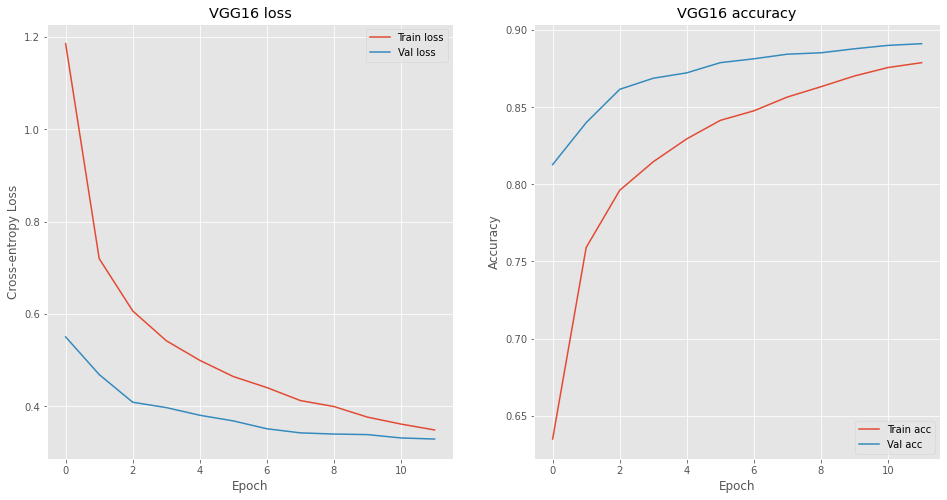

In [92]:
# VGG16 training history
plot_training_history(vgg_results, 'VGG16')

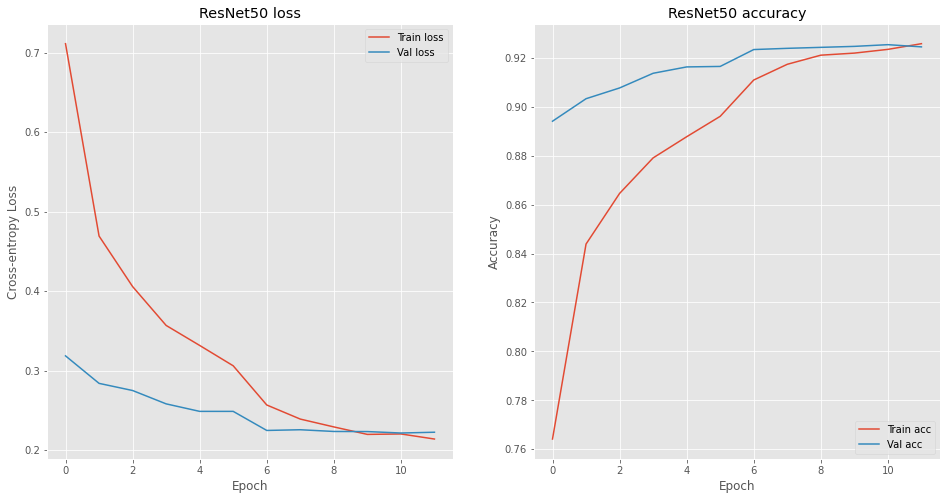

In [93]:
# ResNet50 training history
plot_training_history(resnet_results, 'ResNet50')

### View confusion matrix for both models

We have used accuracy as our main metric since the task is a balanced multiclass classification problem. We can also use a confusion matrix to give a better idea of how well each model has performed. This will show if there are particular classes where the model has low precision/recall.

The confusion matrices below show that the models are fairly similar in their errors. The classes causing most errors for both models are cats & dogs.

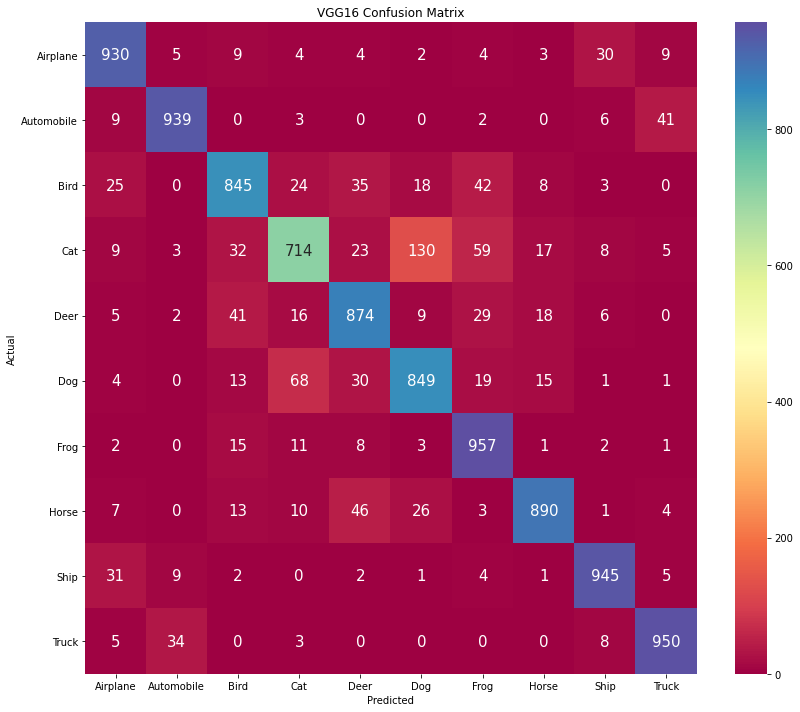

In [94]:
# Convert X-test to 1D array of ints
y_true = y_test.argmax(axis=1)

# Convert predictions to 1D array
vgg_preds = vgg_results['test_preds'].argmax(axis=1)
resnet_preds = resnet_results['test_preds'].argmax(axis=1)

# Calculate confusion matrix
vgg_matrix = confusion_matrix(y_true, vgg_preds)

display_confusion_matrix(vgg_matrix, title='VGG16 Confusion Matrix')

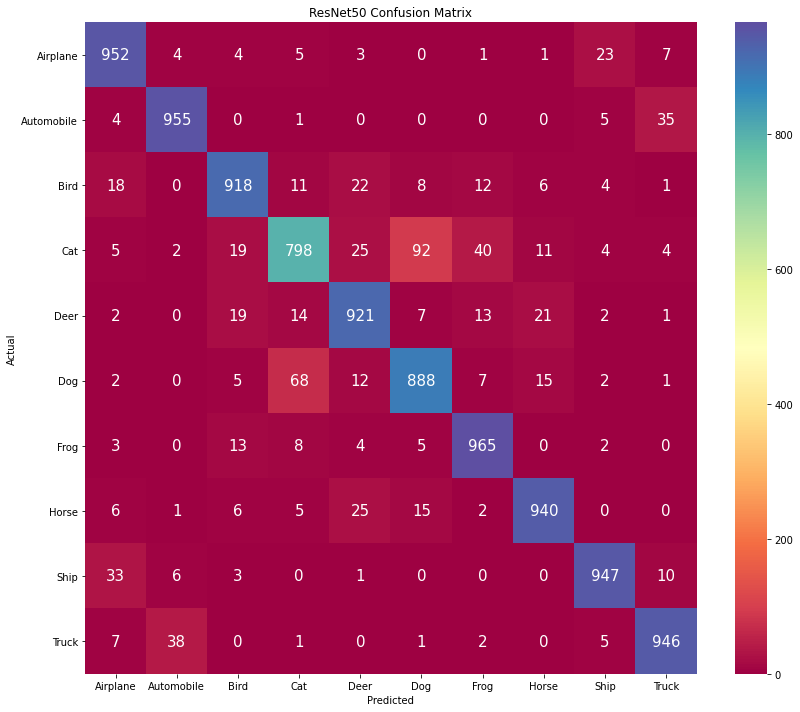

In [95]:
resnet_matrix = confusion_matrix(y_true, resnet_preds)

display_confusion_matrix(resnet_matrix, title='ResNet50 Confusion Matrix')

## Conclusions

As hypothesized the ResNet50 performed better here however the results are a bit different from what was expected. I thought VGG16 would start to overfit however it is ResNet50 that shows more signs of overfitting. This is probably due to differences in the architecture and size of the models; ResNet is considerably larger (40.2M trainable parameters to VGG16's 10.1M) hence it is able to learn quicker.

We have taken every step to ensure that the comparison is as fair as possible however it should be noted that choice of hyperparameters (and fully-connected layer architecture) has a big impact on performance. The decisions we made have been with the interests of making a fair comparison of the models rather than achieving state-of-the-art results. 

### Possible improvements

The purpose of this project was to compare the performance of two separate architectures and was not to optimize performance. Accordingly, we tried to keep things as simple and as fair as possible. I think that the performance could possibly be improved by using more data augmentation (possibly PCA augmentation) and training for longer with a reducing learning rate. Increasing the number of neurons in the dense layers could also perhaps improve performance.

Fine-tuning (i.e. unfreezing layers) could possibly improve performance. This was attempted by unfreezing all layers however the model was too unstable even with low learning rates. Unfreezing only the last few layers was considered as I believe this could improve performance,  this was not done however as the two architectures are very different and there would be no fair way to do this. 